# Proposed Model Structured Neural network (Ablation 1 Longitudinal)


## Initialization

In [1]:
import os

print('Current working directory: ',os.getcwd())

Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


In [2]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.support.initializer import *
from nnodely.support.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely.support import earlystopping

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.1 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


## Datasets

In [3]:
from scipy.interpolate import interp1d

data_folder = os.path.join(os.getcwd(),'Dataset')

####### TRAINING DATA ########
data_folder_train = os.path.join(data_folder,'Complete Dynamics/training')
training_data=pd.read_csv(os.path.join(data_folder_train,'ftg_stanley_total_training.csv'))

####### VALIDATION DATA ########
data_folder_Validation = os.path.join(data_folder,'Complete Dynamics/validation')
Validation_data=pd.read_csv(os.path.join(data_folder_Validation,'ftg_stanley_total_validation.csv'))

####### TEST DATA ########

flag=0 # flag to chosse the test dataset
# flag=0 -> fg_single_mass_processed.csv
# flag=1 -> fg_double_mass_processed.csv
# flag=2 -> Frastagliate_tot.csv
# flag=3 -> Intermedie_tot.csv
# flag=4 -> Normal_1weight_v03.csv
# flag=5 -> Normal_2weights_v025.csv

data_folder_Test= os.path.join(data_folder,'Robusteness')

if flag==0:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'single_mass.csv'))
elif flag==1:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'double_mass.csv'))
elif flag==2:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_1.csv'))
elif flag==3:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_2.csv'))
elif flag==4:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_1weight.csv'))
elif flag==5:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_2weights.csv'))


## MS NN Structure

In [4]:
# create the function computing the longitudinal acceleration with the model-based part
def acc_model_based(Ty,v, 
                    r1,mass,Kd,Cv,Cr,Iw1):  # learnable parameter
    # function inputs:
    # Ty,v --> wheel torques and vehicle speed

    # learnable parameters:
    # r1,mass,Kd,Cv,Cr,Iw1 --> wheel radius,vehicle mass, aero drag, linear drag and rolling resistance coefficients, wheel inertia
    
    # non-trainable parameters
    g_acc     = 9.81       # [m/s^2] gravity acceleration
    
    # function output: longitudinal acceleration, computed using the Newton's vehicle dynamics laws 
    return ((1.0/mass)*( 2*(Ty/r1) - Kd * v**2 - Cv * v) - Cr*g_acc)/(1.0 + (2.0/mass)*(2*(Iw1/r1**2.0)))

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
velocity         = Input('vel')         # [m/s] longitudinal velocity 
current          = Input('crt')         # [I] Motor current  
acc              = Input('acc')         # [m/s^2] Longitudinal acceleration 

# Dimensions of the layers
n  = 10
current_window = 15 # number of samples in the past for the motor current

def acc_pos(T):
    mask_pos = torch.gt(T,0)
    return torch.mul(T,mask_pos)

def acc_neg(T):
    mask_pos = torch.gt(T,0)
    return torch.mul(T,~mask_pos)

r1_guess = Parameter('r1',values=[[5e-3]])
mass_guess = Parameter('mass',values=[[3.5]])  # initial guess for the understeering gradient learnable parameter
Kd_guess = Parameter('Kd',values=[[1e-4]])  # initial guess for the understeering gradient learnable parameter
Cv_guess = Parameter('Cv',values=[[1e-4]])  # initial guess for the understeering gradient learnable parameter
Cr_guess = Parameter('Cr',values=[[1e-4]])  # initial guess for the understeering gradient learnable parameter
Iw1_guess = Parameter('Iw1',values=[[1e-4]])  # initial guess for the understeering gradient learnable parameter

# data-driven layers to estimate the effects of the engine force, by processing a past window of motor torque values
pos = ParamFun(acc_pos)(current.sw(current_window))
neg = ParamFun(acc_neg)(current.sw(current_window))
bias_value=0.0001
torque_layer_11 = Fir(output_dimension=n,b =True, b_init = init_negexp, b_init_params={'size_index':0, 'first_value':bias_value, 'lambda':3}, W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':3})(pos)
torque_layer_21 = Tanh(torque_layer_11)
torque_pos = Linear(torque_layer_21)

torque_layer_12 = Fir(output_dimension=n,b =True, b_init = init_negexp, b_init_params={'size_index':0, 'first_value':bias_value, 'lambda':3}, W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':3})(neg)
torque_layer_22 = Tanh(torque_layer_12)
torque_neg = Linear(torque_layer_22)

# Build a parametric function for the model-based part of the MS-NN
model_based_out = ParamFun(acc_model_based, 
                           parameters_and_constants=[r1_guess,mass_guess,Kd_guess,Cv_guess,Cr_guess,Iw1_guess]
                           )(torque_neg+torque_pos,velocity.last())
# Create neural network output
out = Output('acceleration', model_based_out)


### nnodely definitions

In [5]:
# Create a nnodely model
path_folder   = os.path.join(os.getcwd(),'trained_models','Ablation_longitudinal')    # folder to save the model
long_dynamics   = nnodely(visualizer='Standard',seed=12,workspace=path_folder,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
long_dynamics.addModel('acc',[out])
long_dynamics.addMinimize('acc_error', 
                                    acc.next(),  # next means the first value in the "future"
                                    out, 
                                    loss_function='rmse')


In [6]:
long_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun10': {'code': 'def acc_pos(T):\n'
                                       '    mask_pos = torch.gt(T,0)\n'
                                       '    return torch.mul(T,mask_pos)\n',
                               'in_dim': [{'dim': 1, 'sw': 15}],
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'acc_pos',
                               'params_and_consts': []},
               'FParamFun11': {'code': 'def acc_neg(T):\n'
                                       '    mask_pos = torch.gt(T,0)\n'
                                       '    return torch.mul(T,~mask_pos)\n',
                               'in_dim': [{'dim': 1, 'sw': 15}],
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'acc_neg',

## Training and validation datasets

In [7]:
ratio_rpm_v=4244.0 # ratio ti pass from electrical rpm to m/s

from scipy.constants import g
speed_ms_train=(training_data["Speed"].values)/ratio_rpm_v
torque_train=training_data["current"].values
acc_train=training_data["accx"].values*g
perc=0.6
size_train= round(len(acc_train)*perc)
dataset_training = {'vel': speed_ms_train[:size_train], 'crt': torque_train[:size_train], 'acc' : acc_train[:size_train]}

speed_ms_validation=(Validation_data["Speed"].values)/ratio_rpm_v
torque_validation=Validation_data["current"].values
acc_validation=Validation_data["accx"].values*g
dataset_validation = {'vel': speed_ms_validation, 'crt': torque_validation, 'acc' : acc_validation}

speed_ms_test=(Test_data["Speed"].values)/ratio_rpm_v
torque_test=Test_data["current"].values
acc_test=Test_data["accx"].values*g
dataset_test = {'vel': speed_ms_test, 'crt': torque_test, 'acc' : acc_test}

# Pass the training and the validation datasets to the nnodely structure

long_dynamics.loadData(name='training_set', source=dataset_training)
long_dynamics.loadData(name='validation_set', source=dataset_validation)
long_dynamics.loadData(name='Test_set', source=dataset_test)

============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      1504
Shape of vel:                 (1504, 1, 1)
Shape of crt:                 (1504, 15, 1)
Shape of acc:                 (1504, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      1182
Shape of vel:                 (1182, 1, 1)
Shape of crt:                 (1182, 15, 1)
Shape of acc:                 (1182, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 Test_set
Number of files:              1
Total number of samples:      504
Shape of vel:                 (504, 1, 1)
Shape of crt:                 (504, 15, 1)
Shape of acc:                 (504, 1, 1)


## Training

In [ ]:
num_epochs = 1000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 500
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = long_dynamics.trainAndAnalyze(train_dataset='training_set', validation_dataset='validation_set', test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'acc_error'})  
  # long_dynamics.saveModel()
else:
  # Load the trained model
  long_dynamics.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['acc']
num of epochs:                20000
update per epochs:            15
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'acc_error', 'patience': 500}
train dataset:                training_set
	- batch size:                100
	- num of samples:            1504
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            1182
minimizers:                   {'acc_error': {'A': 'SamplePart17',
                                             'B': 'ParamFun15',
                                             'loss': 'rmse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'Cr'},
                               {'params': 'Cv'},
                        

In [9]:
# Print the trained NN parameters
long_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun10': {'code': 'def acc_pos(T):\n'
                                       '    mask_pos = torch.gt(T,0)\n'
                                       '    return torch.mul(T,mask_pos)\n',
                               'in_dim': [{'dim': 1, 'sw': 15}],
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'acc_pos',
                               'params_and_consts': []},
               'FParamFun11': {'code': 'def acc_neg(T):\n'
                                       '    mask_pos = torch.gt(T,0)\n'
                                       '    return torch.mul(T,~mask_pos)\n',
                               'in_dim': [{'dim': 1, 'sw': 15}],
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'acc_neg',

## Results

RMSE on the test set:  [0.77869351] [m/s^2] 


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

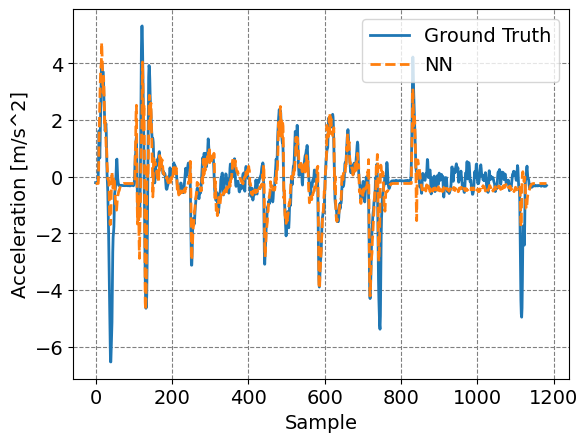

In [10]:
# Test on the validation dataset
num_samples_use  = np.size(acc_validation)-current_window
samples_Validation_set = long_dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = long_dynamics(samples_Validation_set, sampled=True)
out_nn_Validation_set_extract = np.asarray(out_nn_test_set['acceleration'])

# Extract the samples
samples_Validation_set_extract = np.zeros((len(samples_Validation_set['acc']),1))
for i in range(0,len(samples_Validation_set_extract)):
  samples_Validation_set_extract[i] = samples_Validation_set['acc'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_Validation_set_extract)):
  mse_calc = mse_calc + (samples_Validation_set_extract[i] - out_nn_Validation_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_Validation_set_extract))
print('RMSE on the test set: ', mse_calc, '[m/s^2] ')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_Validation_set_extract,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_Validation_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()



In [27]:
num_samples_use

1503.6

RMSE on the test set:  [0.41961086]  [m/s^2]


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

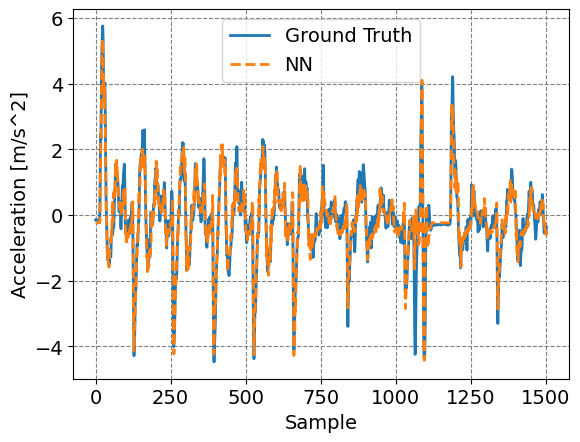

In [28]:
# Test on the training dataset
num_samples_use  = size_train-current_window
samples_training_set = long_dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_trainig_set  = long_dynamics(samples_training_set, sampled=True)
out_nn_training_set_extract = np.asarray(out_nn_trainig_set['acceleration'])

# Extract the samples
samples_training_set_extract = np.zeros((len(samples_training_set['acc']),1))
for i in range(0,len(samples_training_set_extract)):
  samples_training_set_extract[i] = samples_training_set['acc'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_training_set_extract)):
  mse_calc = mse_calc + (samples_training_set_extract[i] - out_nn_training_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_training_set_extract))
print('RMSE on the test set: ', mse_calc, ' [m/s^2]')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_training_set_extract,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_training_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()
  
  

RMSE on the test set:  [0.38890503]  [m/s^2]


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

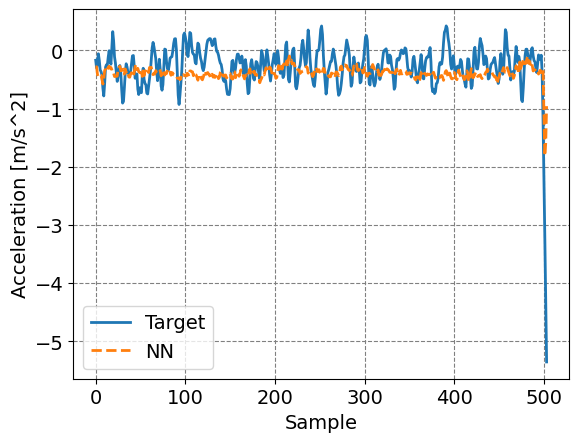

In [29]:
# Test on the test dataset
num_samples_use  = np.size(acc_test)-current_window
samples_test_set = long_dynamics.getSamples('Test_set', index=0, window=num_samples_use) 
out_nn_test_set  = long_dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['acceleration'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['acc'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, ' [m/s^2]')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract,label='Target',linewidth=2)
  plt.plot(out_nn_test_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()

  